In [85]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit_nature.drivers import Molecule

from quantum_serverless import QuantumServerless
from quantum_serverless.library.groundstate_sweep import groundstate_solver_parallel_sweep

### Initialization

In [2]:
# default initialization
serverless = QuantumServerless()

# from configuration object
config = {"providers": [{"name": "ibm"}]}
serverless = QuantumServerless(config)

# from config file
serverless = QuantumServerless.load_configuration("./serverless_config.json")

serverless

<QuantumServerless: providers [local, ibm], clusters [local, ibm_remote]>

In [3]:
# get available providers
serverless.providers()

[<Provider: local>, <Provider: ibm>]

In [4]:
# get available clusters
serverless.clusters()

[<Cluster: local>, <Cluster: ibm_remote>]

In [5]:
# get available backends
serverless.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

### Grounstate solver sweep

![parameter sweep](images/parameter_sweep.png)

In [6]:
# help(groundstate_solver_parallel_sweep)

In [87]:
%%capture

with serverless:  # or serverless.provider("ibm")
    results = groundstate_solver_parallel_sweep(
        molecules=[["H", "H"]],
        n_geometries=500
    )

In [92]:
# print results
for sweep in results[:1]:
    print("")
    print(sweep.parameters["molecule"]) # run parameters
    print("---")
    print(sweep.result) # run result


Molecule:
	Multiplicity: 1
	Charge: 0
	Unit: Angstrom
	Geometry:
		H	[0.18096265969800426, 0.20252633293386496, 0.3446812030133442]
		H	[0.10246689460097436, 0.14133061442497988, 0.4279414356770125]
---
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -2.558844783441
  - computed part:      -2.558844783441
~ Nuclear repulsion energy (Hartree): 4.077988375198
> Total ground state energy (Hartree): 1.519143591758
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.53560423  0.64979546  1.46004518]
 
  0: 
  * Electronic dipole moment (a.u.): [0.53560443  0.64979561  1.46004498]
    - computed part:      [0.53560443  0.64979561  1.46004498]
  > Dipole moment (a.u.): [-0.0000002  -0.00000015  0.0000002]  Total: 0.00000032
                 (debye): [-0.0000005  -0.00000037  0.00000051]  Total: 0.00000081
 


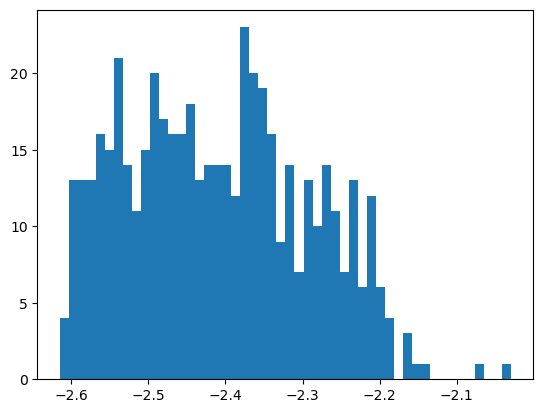

In [91]:
energies = [sweep.result.groundenergy for sweep in results]

plt.hist(energies, bins=50)
plt.show()

### Example with defined molecules

In [22]:
%%capture

with serverless.provider("ibm"):
    results = groundstate_solver_parallel_sweep(
        molecules=[
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1),
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.635]]], charge=0, multiplicity=1),
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.535]]], charge=0, multiplicity=1),
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.435]]], charge=0, multiplicity=1),
            Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.335]]], charge=0, multiplicity=1)
        ]
    )

In [94]:
# # print results
# for sweep in results:
#     print("")
#     print(sweep.parameters["molecule"]) # run parameters
#     print("---")
#     print(sweep.result) # run result